In [ ]:
!pip install xgboost scikit-learn tensorflow

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

import xgboost as xgb
from sklearn.svm import SVC
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Dense


In [ ]:
# Load your CSV (already uploaded in Colab)
df = pd.read_csv("/content/Augmentedon3.csv")

# Features and labels
X = df.drop("Healthy", axis=1).values
y = df["Healthy"].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features for NN and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Step 1: Train XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Step 2: Get leaf indices (new features)
X_train_leaf = xgb_model.apply(X_train)
X_test_leaf = xgb_model.apply(X_test)

# Step 3: Train SVM on leaf indices
svm = SVC(kernel='rbf', C=1.0)
svm.fit(X_train_leaf, y_train)

# Step 4: Predict and evaluate
y_pred_svm = svm.predict(X_test_leaf)
print("XGBoost + SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


XGBoost + SVM Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       1.00      0.60      0.75        10

    accuracy                           0.82        22
   macro avg       0.88      0.80      0.80        22
weighted avg       0.86      0.82      0.81        22



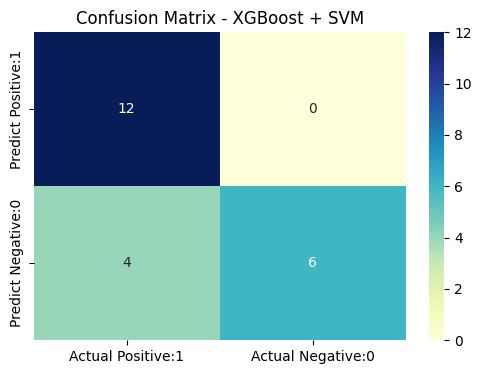

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Υπολογισμός confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Δημιουργία DataFrame για heatmap
cm_matrix = pd.DataFrame(data=cm,
                         columns=['Actual Positive:1', 'Actual Negative:0'],
                         index=['Predict Positive:1', 'Predict Negative:0'])

# Οπτικοποίηση
plt.figure(figsize=(6,4))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix - XGBoost + SVM")
plt.show()


In [ ]:
# Step 1: Define model using Functional API
input_layer = Input(shape=(X_train_scaled.shape[1],))  # Fixed shape definition
x = Dense(64, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
feature_layer = Dense(16, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(feature_layer)

# Create full model
nn_model = Model(inputs=input_layer, outputs=output_layer)
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 2: Train model
nn_model.fit(X_train_scaled, y_train, epochs=20, batch_size=8, verbose=0)

# Step 3: Create feature extractor model
feature_extractor = Model(inputs=nn_model.input, outputs=feature_layer)

# Step 4: Extract features
X_train_nn_features = feature_extractor.predict(X_train_scaled)
X_test_nn_features = feature_extractor.predict(X_test_scaled)  # Fixed typo: X_test_scaled

# Step 5: Train XGBoost on extracted features
xgb_from_nn = xgb.XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1)
xgb_from_nn.fit(X_train_nn_features, y_train)

# Step 6: Evaluate
y_pred_nn_xgb = xgb_from_nn.predict(X_test_nn_features)
print("NN + XGBoost Accuracy:", accuracy_score(y_test, y_pred_nn_xgb))
print(classification_report(y_test, y_pred_nn_xgb))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
NN + XGBoost Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       0.88      0.70      0.78        10

    accuracy                           0.82        22
   macro avg       0.83      0.81      0.81        22
weighted avg       0.83      0.82      0.82        22



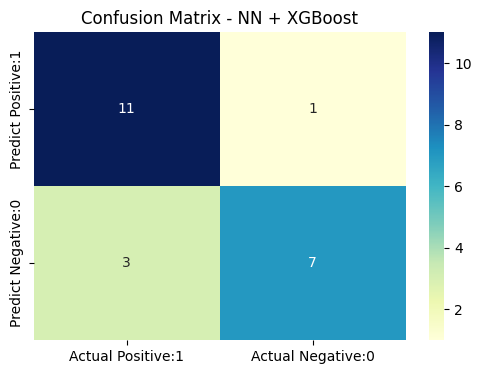

In [ ]:
# Υπολογισμός confusion matrix
cm = confusion_matrix(y_test, y_pred_nn_xgb)

# Οπτικοποίηση
cm_matrix = pd.DataFrame(data=cm,
                         columns=['Actual Positive:1', 'Actual Negative:0'],
                         index=['Predict Positive:1', 'Predict Negative:0'])

plt.figure(figsize=(6,4))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix - NN + XGBoost")
plt.show()


In [ ]:
plain_xgb = xgb.XGBClassifier()
plain_xgb.fit(X_train, y_train)
y_pred_plain = plain_xgb.predict(X_test)
print("Plain XGBoost Accuracy:", accuracy_score(y_test, y_pred_plain))


Plain XGBoost Accuracy: 0.8636363636363636


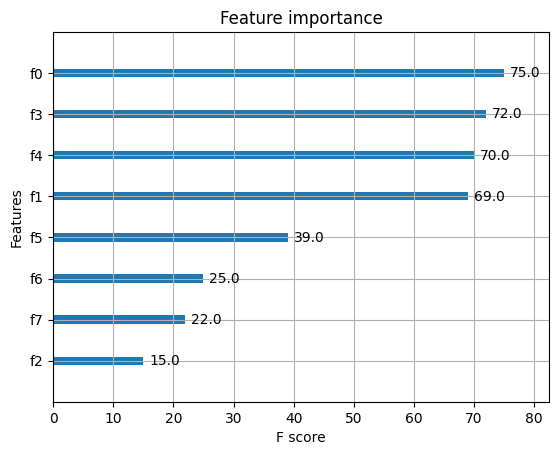

In [ ]:
import matplotlib.pyplot as plt
xgb.plot_importance(plain_xgb)
plt.show()